# Beer Consumption


## Overview


## Importing Libraries

In [239]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.linear_model import LinearRegression, Lasso # type: ignore
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error # type: ignore

## 1. Data Loading

In [240]:
df = pd.read_csv('data/Consumo_cerveza_SP.csv')

## 2. Data Proprocessing

### 2.1 Data Exploring

In [241]:
df.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    object 
 2   Temperatura Minima (C)       365 non-null    object 
 3   Temperatura Maxima (C)       365 non-null    object 
 4   Precipitacao (mm)            365 non-null    object 
 5   Final de Semana              365 non-null    float64
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 51.6+ KB


In [243]:
df.dtypes

Data                            object
Temperatura Media (C)           object
Temperatura Minima (C)          object
Temperatura Maxima (C)          object
Precipitacao (mm)               object
Final de Semana                float64
Consumo de cerveja (litros)    float64
dtype: object

### 2.2 Data Cleaning

In [244]:
df.columns

Index(['Data', 'Temperatura Media (C)', 'Temperatura Minima (C)',
       'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana',
       'Consumo de cerveja (litros)'],
      dtype='object')

In [245]:
df.columns = ['datetime', 'mean_temp', 'min_temp', 'max_temp', 'precipitation', 'end_of_week', 'beer_consumption']

In [246]:
df.isnull().sum()

datetime            576
mean_temp           576
min_temp            576
max_temp            576
precipitation       576
end_of_week         576
beer_consumption    576
dtype: int64

In [247]:
df[df.isnull().any(axis=1)]

,datetime,mean_temp,min_temp,max_temp,precipitation,end_of_week,beer_consumption
365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
df.dropna(inplace=True)

In [249]:
df.duplicated().sum()

np.int64(0)

In [250]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [251]:
df['min_temp'] = df['min_temp'].apply(lambda x: x.replace(',', '.')).astype(float)
df['mean_temp'] = df['mean_temp'].apply(lambda x: x.replace(',', '.')).astype(float)
df['max_temp'] = df['max_temp'].apply(lambda x: x.replace(',', '.')).astype(float)
df['precipitation'] = df['precipitation'].apply(lambda x: x.replace(',', '.')).astype(float)

In [252]:
df['end_of_week'] = df['end_of_week'].apply(lambda x: 1 if x else 0)

### 2.3 Data Visualization

### 2.4 Handle Missing Values

In [253]:
df.isna().sum()

datetime            0
mean_temp           0
min_temp            0
max_temp            0
precipitation       0
end_of_week         0
beer_consumption    0
dtype: int64

### 2.5 Outlier Handling

In [254]:
float_cols = df.select_dtypes(include=['float64']).columns

In [255]:
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.stats import zscore, iqr
from sklearn.ensemble import IsolationForest
import numpy as np

def iqr_outliers(df, columns, iqr_factor=1.5, remove=False, return_index = False):
    outliers_info = {}
    outliers_indexs = set()

    for column in columns:
        Q1 = np.percentile(df[column].dropna(), 25)
        Q3 = np.percentile(df[column].dropna(), 75)
        IQR = iqr(df[column].dropna())

        lim_inf = Q1 - iqr_factor * IQR
        lim_sup = Q3 + iqr_factor * IQR
        outliers = df[(df[column] < lim_inf) | (df[column] > lim_sup)]

        if not outliers.empty:
          outliers_info[column] = len(outliers)
          outliers_indexs.update(outliers.index)

    df_results = pd.DataFrame(outliers_info, index=['outliers']).T
    
    if remove:
        df.drop(index=outliers_indexs, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'\n{len(outliers_indexs)} were removed.')
    
    if return_index:
        return outliers_indexs
    else: 
        return df_results

def plot_boxplots(df, columns, n_cols=3, figsize=(5, 4)):
    n_rows = math.ceil(len(columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        df.boxplot(column=column, ax=axes[i])
        axes[i].set_title(column)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def z_score_outliers(df, cols, threshold=3, remove=False, return_index=False):
    outliers_info = {}
    outliers_indexs = set()

    for col in cols:
        z_scores = zscore(df[col].dropna())

        outliers = df[col][(z_scores > threshold) | (z_scores < -threshold)]

        if not outliers.empty:
            outliers_info[col] = len(outliers)
            outliers_indexs.update(outliers.index)
 
    df_results = pd.DataFrame(outliers_info, index=['outliers']).T

    if remove:
        df.drop(index=outliers_indexs, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'\n{len(outliers_indexs)} were removed.')
    
    if return_index:
        return outliers_indexs
    else: 
        return df_results

def isolation_forest_outliers(df, columns, contamination=0.05, remove=False, return_index=False):
    outliers_info = {}
    
    iso_for = IsolationForest(contamination=contamination)
    df_copy = df.copy()
    df_copy['outlier_score'] = iso_for.fit_predict(df_copy[columns])
    
    outliers = df_copy[df_copy['outlier_score'] == -1]
    outliers_index = outliers.index.tolist()

    if remove:
        df.drop(index=outliers_index, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'{len(outliers_index)} were dropped')

    if return_index:
        return outliers_index
    else:
        return print(f'{len(outliers)} outliers')

In [256]:
iqr_outliers(df, float_cols, iqr_factor=1.5,return_index=False)

,outliers
max_temp,1
precipitation,64


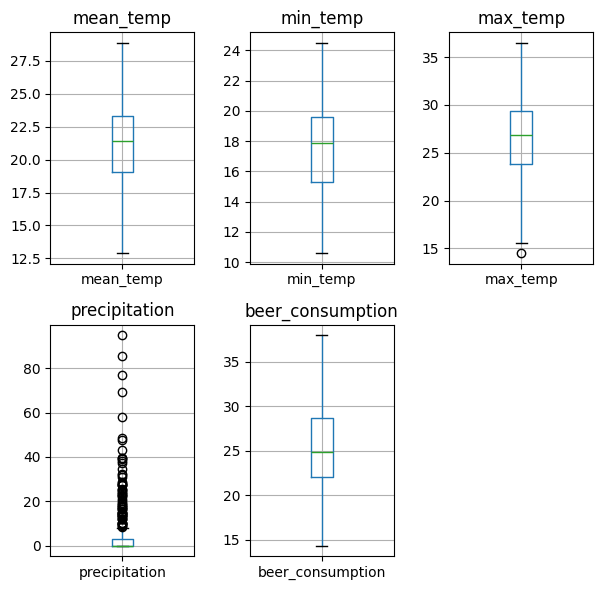

In [257]:
plot_boxplots(df, float_cols, n_cols=3, figsize=(6, 6))

In [258]:
z_score_outliers(df, float_cols, threshold=3,return_index=False)

,outliers
precipitation,8


In [259]:
isolation_forest_outliers(df, float_cols)

19 outliers


I don't drop any rows because I don't consider outliers can impact the results.

### 2.6 Feature Engineering

#### 2.6.1 Feature Selection

##### Continous -> Continous

In [260]:
def corr_pearson(df, features,target , method='pearson', show_plot=False):
    
    float_cols = features.append(pd.Index([target]))
    df = df[float_cols]
    corr_info = df.corr(method=method)

    if show_plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_info, annot=True, cmap='coolwarm', center=0)
        plt.show()
    else:
        corr_info = corr_info[target].sort_values(ascending=False)
        return corr_info

In [261]:
def corr_spearman(df,features,target):

    corr_info = []

    for feature in features:
        spearman_corr = df[feature].corr(df[target], method="spearman")
        corr_info.append({
            "Feature": feature,
            "Spearman Correlation": spearman_corr
        })
    
    return pd.DataFrame(corr_info).sort_values('Spearman Correlation', ascending=False)

In [262]:
from sklearn.feature_selection import mutual_info_regression

def mutual_info(df, features, target):
    results = mutual_info_regression(df[features], df[target])
    results = pd.Series(results, index=features)
    return results.sort_values(ascending=False)

In [263]:
float_features = float_cols.drop('beer_consumption')

In [264]:
corr_pearson(df, float_features, 'beer_consumption', show_plot=False)

beer_consumption    1.000000
max_temp            0.642672
mean_temp           0.574615
min_temp            0.392509
precipitation      -0.193784
Name: beer_consumption, dtype: float64

In [265]:
corr_spearman(df,float_features , 'beer_consumption')

,Feature,Spearman Correlation
2,max_temp,0.641289
0,mean_temp,0.569998
1,min_temp,0.391495
3,precipitation,-0.172381


In [266]:
mutual_info(df,float_features , 'beer_consumption')

max_temp         0.303046
mean_temp        0.228095
min_temp         0.113478
precipitation    0.058368
dtype: float64

#### categorical -> continous

In [267]:
from scipy.stats import f_oneway

def one_way_anova(df, features, target, return_results = False):
    results = []
    important_features = []
    no_important_features = []

    for feature in features:
        groups = [df[df[feature] == group][target].dropna() for group in df[feature].unique()]
        f_stat, p_value = f_oneway(*groups)

        if p_value < 0.05:
            important_features.append(feature)
            is_important = True
        else:
            no_important_features.append(feature)
            is_important = False
        
        results.append({
            "Feature": feature,
            "F-Statistic": f_stat,
            "P-Value": p_value,
            "Is Important": is_important
        })

    result_df = pd.DataFrame(results).sort_values('P-Value')

    if return_results:
        print(",".join(important_features))
        return important_features, no_important_features
    else:
        return result_df

In [268]:
categorical_features = df.select_dtypes(include=['int']).columns

In [269]:
one_way_anova(df, categorical_features, 'beer_consumption', return_results=False)

,Feature,F-Statistic,P-Value,Is Important
0,end_of_week,124.913906,4.007969e-25,True


#### selecting the important features

In [270]:
df_model = df[['mean_temp', 'min_temp', 'max_temp','end_of_week', 'beer_consumption']]

#### 2.6.2 Feature Transformation

### 2.7 Feature Encoding

### 2.8 Feature Scaling

## 3. Machine Learning Models

In [271]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

regression_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R²'])
models = {}

def save_metrics(model, y_test, y_pred):
    global regression_metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    new_row = {
        'Model': model,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }
    
    new_row_df = pd.DataFrame([new_row]).dropna(axis=1, how='all')
    regression_metrics = pd.concat([regression_metrics, new_row_df], ignore_index=True)

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

In [273]:
x = df_model.drop(columns='beer_consumption')
y = df_model['beer_consumption']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### 3.1 Linear Regression

In [274]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_1 = lr.predict(x_test)

save_metrics('Linear Regression', y_test, y_pred_1)
models['Linear Regression'] = lr

C:\Users\harol\AppData\Local\Temp\ipykernel_24068\2245341504.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_metrics = pd.concat([regression_metrics, new_row_df], ignore_index=True)


In [275]:
lr_lasso = Lasso()
lr_lasso.fit(x_train, y_train)
y_pred_2 = lr_lasso.predict(x_test)

save_metrics('Lasso', y_test, y_pred_2)
models['Linear Lasso'] = lr_lasso

In [276]:
lr_ridge= Ridge()
lr_ridge.fit(x_train, y_train)
y_pred_3 = lr_ridge.predict(x_test)

save_metrics('Ridge', y_test, y_pred_3)
models['Linear Ridge'] = lr_ridge

In [277]:
lr_elasticnet = ElasticNet()
lr_elasticnet.fit(x_train, y_train)
y_pred_4 = lr_elasticnet.predict(x_test)

save_metrics('ElasticNet', y_test, y_pred_4)
models['Linear ElasticNet'] = lr_elasticnet

### 3.2 DecisionTreeRegressor

In [278]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(criterion="squared_error", max_depth=3)
dtr.fit(x_train, y_train)
y_pred_5 = dtr.predict(x_test)
save_metrics('Decision Tree Regressor', y_test, y_pred_5)
models['Decision Tree Regressor'] = dtr

### 3.3 Bagging Regressor

In [279]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

base_model = DecisionTreeRegressor(max_depth=3, criterion="squared_error")
bagging = BaggingRegressor(estimator=base_model, n_estimators=150)

bagging.fit(x_train, y_train)
y_pred_6 = bagging.predict(x_test)
save_metrics('Bagging Regressor', y_test, y_pred_6)
models['Bagging Regressor'] = bagging

### 3.4 Random Forest

In [280]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=150, max_depth=3)
rf.fit(x_train, y_train)
y_pred_7 = rf.predict(x_test)

save_metrics('Random Forest Regressor', y_test, y_pred_7)
models['Random Forest Regressor'] = rf

### 3.5 Gradient Boosting Regressor

In [281]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=150, max_depth=3)
gbr.fit(x_train, y_train)
y_pred_8 = gbr.predict(x_test)

save_metrics('Gradient Boosting Regressor', y_test, y_pred_8)
models['Gradient Boosting Regressor'] = gbr

### 3.6 Adaptive Boosting Regressor

In [282]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor(n_estimators=150, learning_rate=0.95)
abr.fit(x_train, y_train)
y_pred_9 = abr.predict(x_test)

save_metrics('AdaBoost Regressor', y_test, y_pred_9)
models['AdaBoost Regressor'] = abr

## 4. Model Evaluation

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_test, y_preds):
    n_preds = len(y_preds)
    n_cols = 3
    n_rows = (n_preds + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, y_pred in enumerate(y_preds):
        residuals = y_test - y_pred
        sns.histplot(residuals, kde=True, bins=30, ax=axes[i])
        model_name = regression_metrics.iloc[i]['Model']
        axes[i].set_title(f"{model_name}")
        axes[i].set_xlabel("Residuals")
        axes[i].set_ylabel("Frequency")
        axes[i].axvline(0, color='red', linestyle='--')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

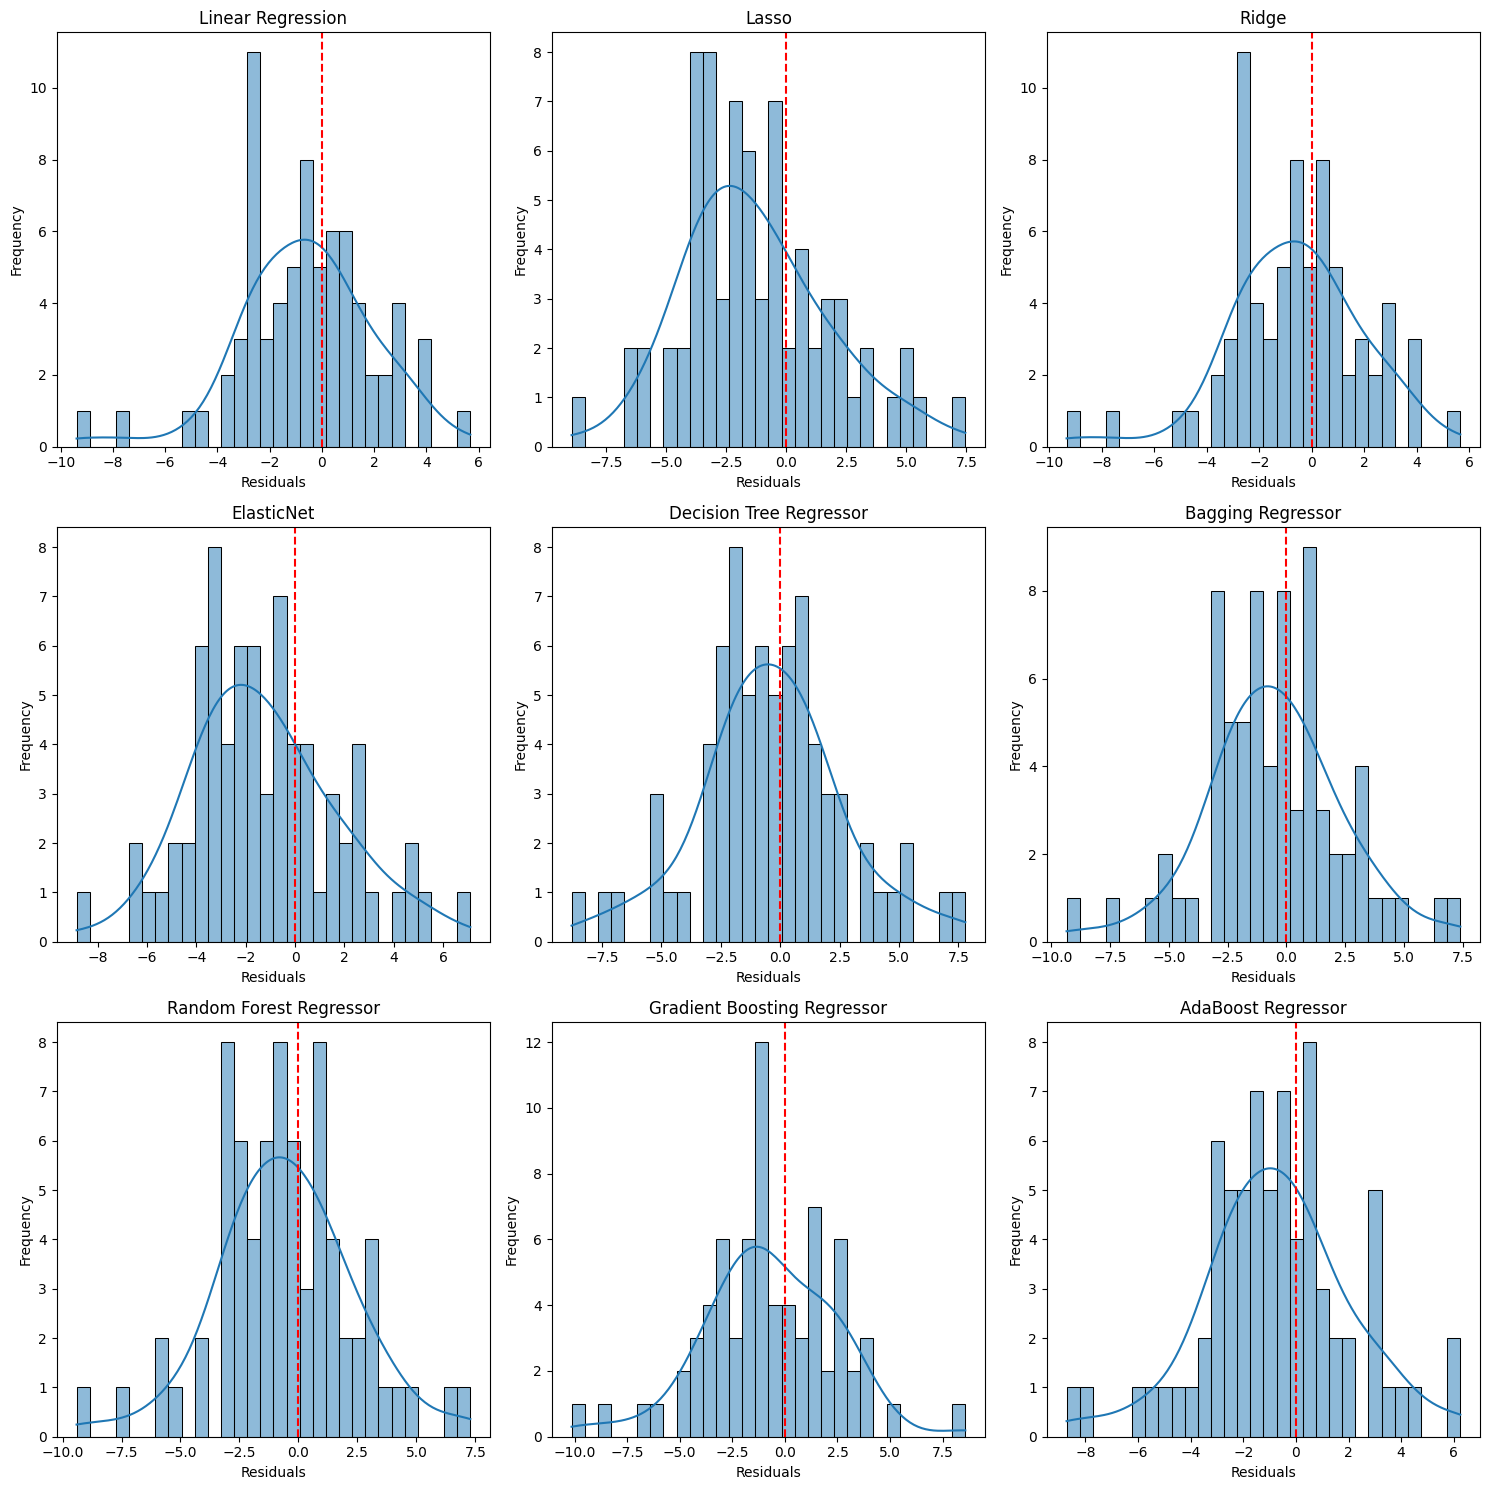

In [284]:
y_preds = [y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, y_pred_6, y_pred_7, y_pred_8, y_pred_9]
plot_residuals(y_test, y_preds)

In [285]:
def scatter_plot(y_test, y_preds):
    n_preds = len(y_preds)
    n_cols = 3
    n_rows = (n_preds + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, y_pred in enumerate(y_preds):
        plt.sca(axes[i])
        plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonal
        model_name = regression_metrics.iloc[i]['Model']
        plt.title(f'{model_name}')
        plt.xlabel('True Values')
        plt.ylabel('Predict Values')
        plt.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

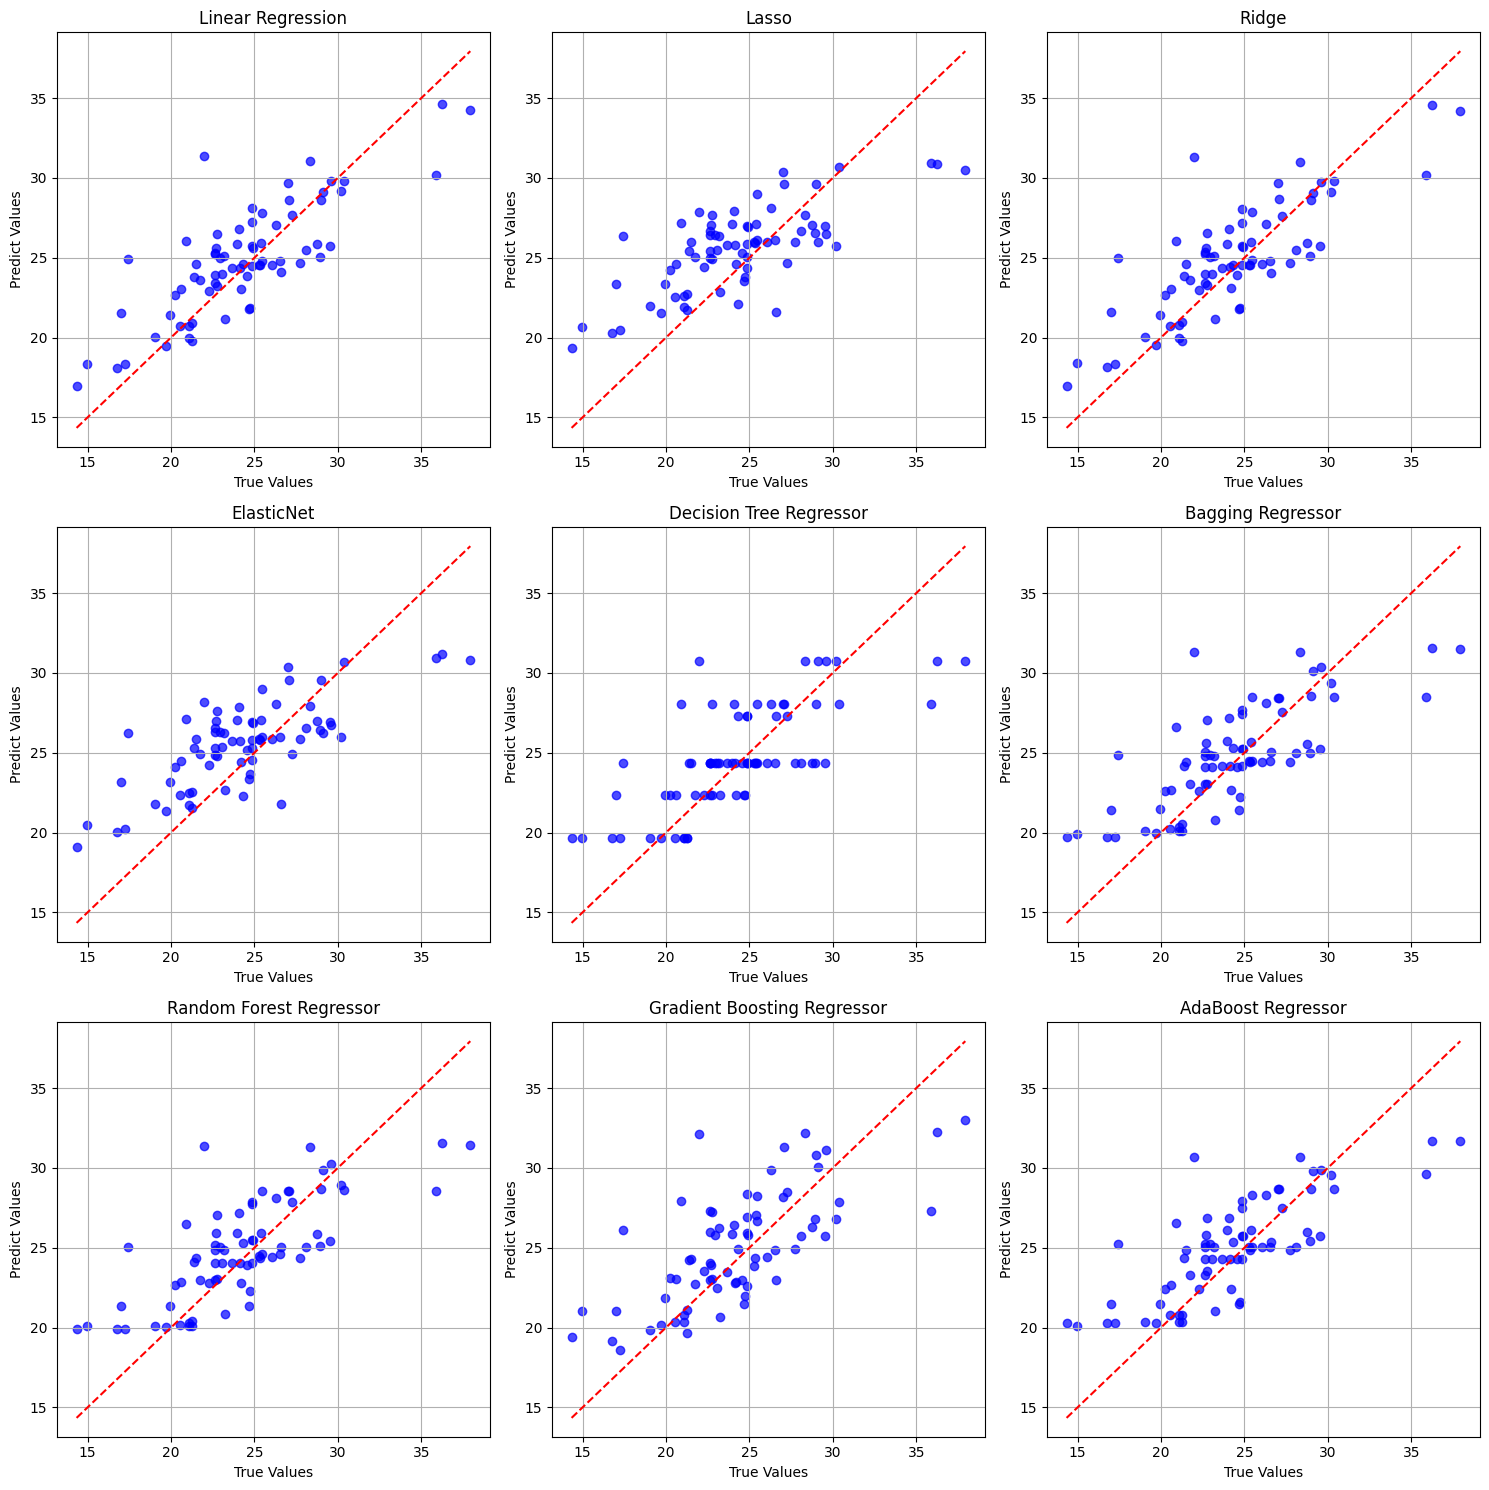

In [286]:
scatter_plot(y_test, y_preds)

## Model Optimization

### General metrics

In [287]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,MAPE
0,Linear Regression,1.987359,6.743421,2.596810,0.643444,0.086264
1,Lasso,2.743377,10.971558,3.312334,0.419882,0.121258
2,Ridge,1.989395,6.752282,2.598515,0.642975,0.086419
3,ElasticNet,2.649104,10.348774,3.216951,0.452812,0.117010
4,Decision Tree Regressor,2.314763,9.403117,3.066450,0.502813,0.099658
5,Bagging Regressor,2.243472,8.597181,2.932095,0.545427,0.097308
6,Random Forest Regressor,2.277536,8.714656,2.952060,0.539215,0.099006
7,Gradient Boosting Regressor,2.525224,10.301064,3.209527,0.455334,0.108818
8,AdaBoost Regressor,2.221038,8.347783,2.889253,0.558613,0.097779


### Model Validation

In [288]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score

def kfold_regression_validation(X, y, models, n_splits=5, metrics=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']):

    kf = KFold(n_splits=n_splits, shuffle=True)
    results = {metric: {} for metric in metrics}
    
    for metric in metrics:
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=metric)
            results[metric][name] = {'scores': scores, 'mean_score': np.mean(scores)}
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(15, num_metrics * 3))
    
    for i, metric in enumerate(metrics):
        model_names = list(results[metric].keys())
        means = [results[metric][n]['mean_score'] for n in model_names]
        best_model = model_names[np.argmax(means)]
        
        axes[i].bar(model_names, means, color=['blue' if n != best_model else 'green' for n in model_names])
        axes[i].set_ylabel(f"{metric}")
        axes[i].set_title(f"\nModel Comparison for {metric}\nBest model: {best_model}", fontsize=14)
        axes[i].tick_params(axis='x', rotation=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


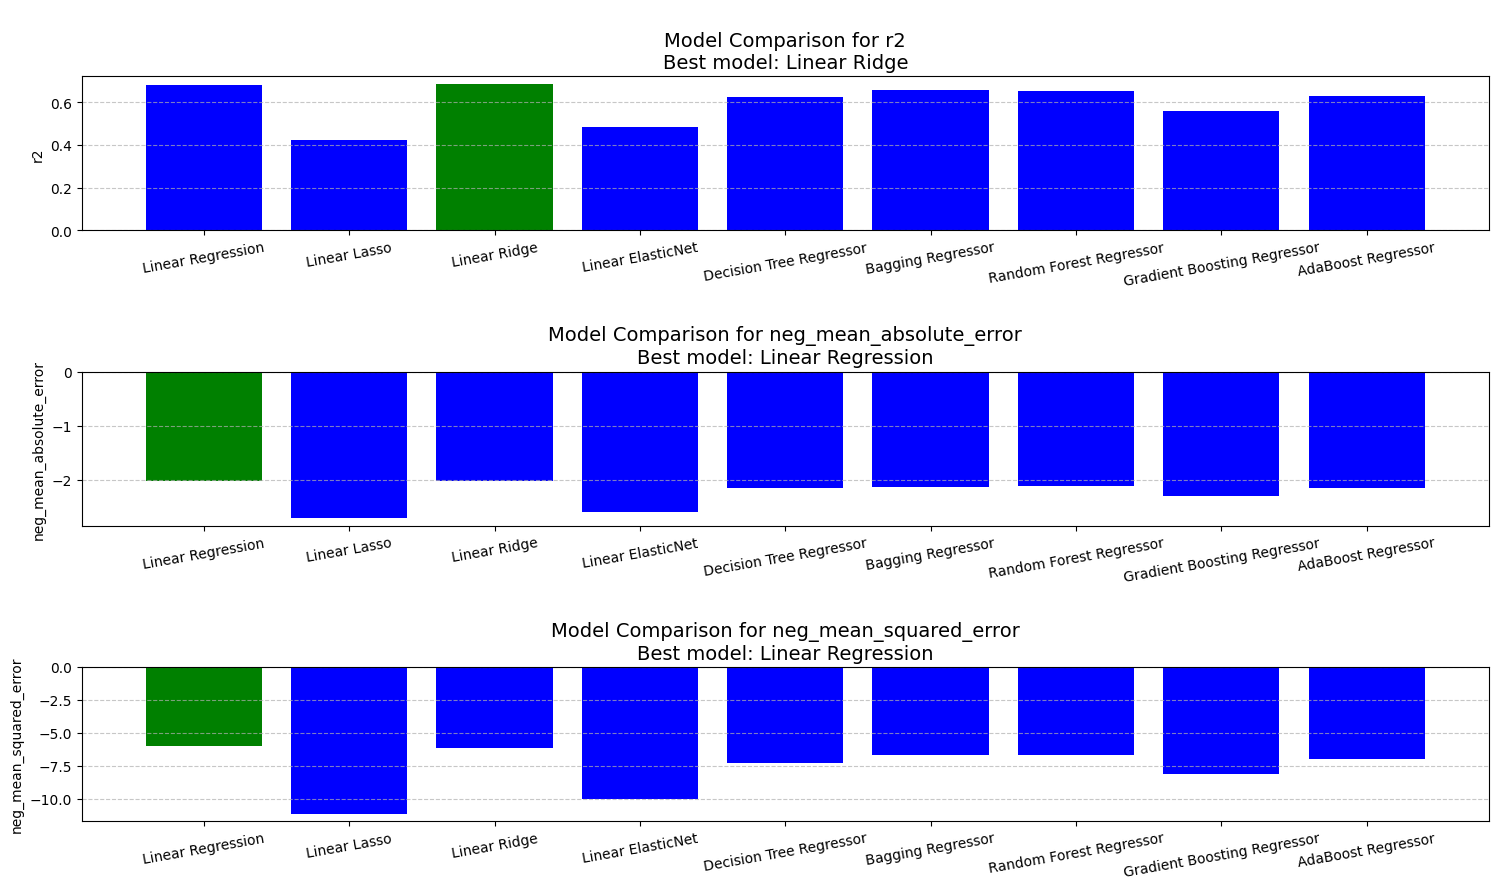

In [289]:
kfold_regression_validation(x, y, models, n_splits=5)

In this situation, I will realize hyperparameter tuning for `Linear Regression` and `Linear Ridge`

### Hyperparameter Tuning